In [ ]:
from dataclasses import asdict

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import optim

In [ ]:
from dataset.datasets import get_dataset
from settings import TrainingSettings, AnnotationSettings, AudioProcessingSettings, CNNSettings, EvaluationSettings, \
    DatasetSettings
from main import train_epoch, evaluate
from model.cnn import CNN

In [ ]:
training_settings: TrainingSettings = TrainingSettings(epochs=30, scheduler=False, num_workers=16)
audio_settings: AudioProcessingSettings = AudioProcessingSettings()
annotation_settings: AnnotationSettings = AnnotationSettings(time_shift=0.0)
dataset_settings = DatasetSettings(
    audio_settings=audio_settings,
    annotation_settings=annotation_settings,
)
cnn_settings = CNNSettings(
    n_classes=annotation_settings.n_classes, n_mels=audio_settings.n_mels
)
evaluation_settings = EvaluationSettings()

device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)

In [ ]:
from matplotlib.colors import ListedColormap
from matplotlib import color_sequences

print(color_sequences)

colors = np.array([
    [230, 25, 75],
    [60, 180, 75],
    [255, 225, 25],
    [0, 130, 200],
    [245, 130, 48],
    [145, 30, 180],
    [70, 240, 240],
    [240, 50, 230],
    [210, 245, 60],
    [250, 190, 190],
    [0, 128, 128],
    [230, 190, 255],
    [170, 110, 40],
    [255, 250, 200],
    [128, 0, 0],
    [170, 255, 195],
    [128, 128, 0],
    [255, 215, 180],
    [0, 0, 128],
    [128, 128, 128],
    [0, 0, 0],
]) / 255
colormap = ListedColormap(colors, N=21)

# Plot a pseudo pr curve
for i in range(10):
    x = np.linspace(0, 1, 100)
    y = np.sin(x * np.pi * i) * 0.5 + 0.5
    plt.plot(x, y, color=colors[i], label=f"Class {i}")
plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve")

In [ ]:
loader_train, loader_val, loader_test_rbma, loader_test_mdb = get_dataset(
    training_settings, audio_settings, annotation_settings
)

In [ ]:
model = CNN(**asdict(cnn_settings))
model.to(device)

In [ ]:
max_lr = training_settings.learning_rate
initial_lr = max_lr / 25
_min_lr = initial_lr / 1e4
initial_lr = (
    training_settings.learning_rate
    if not training_settings.scheduler
    else initial_lr
)
optimizer = optim.RAdam(
    model.parameters(), lr=initial_lr, weight_decay=1e-5
)
scheduler = (
    optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=max_lr,
        steps_per_epoch=len(loader_train),
        epochs=training_settings.epochs,
    )
    if training_settings.scheduler
    else None
)
error = torch.nn.BCEWithLogitsLoss(reduction="none")
scaler = torch.cuda.amp.GradScaler()

In [ ]:
model.to(device)
best_loss = float("inf")
best_score = 0
last_improvement = 0
for epoch in range(10):
    train_loss = train_epoch(
        epoch,
        loader_train,
        device,
        None,
        error,
        model,
        optimizer,
        scaler,
        scheduler,
        tensorboard_writer=None,
    )
    val_loss, f_score, avg_f_score = evaluate(
        epoch,
        model,
        loader_val,
        error,
        device,
        evaluation_settings.ignore_beats,
        tensorboard_writer=None,
        tag="Validation",
    )
    print(
        f"Epoch: {epoch + 1} "
        f"Loss: {train_loss * 100:.4f}\t "
        f"Val Loss: {val_loss * 100:.4f} F-Score: {avg_f_score * 100:.4f}/{f_score * 100:.4f}"
    )

In [ ]:
torch.cuda.empty_cache()
model.cpu()
loader = iter(loader_test_rbma)

In [ ]:
spec, target, annotation = next(loader)
model.eval()
with torch.no_grad():
    output = model(spec)

In [ ]:
print(output.shape)
print(target.shape)
print(spec.shape)

In [ ]:
section = range(1000, 20000)
plt.figure(figsize=(10, 10))
plt.plot(output[0][0][section].numpy(), label="Output")
plt.legend()
plt.show()

In [ ]:
section = range(1000, 20000)
plt.figure(figsize=(10, 10))
plt.plot(output[0][0][section].numpy(), label="Output")
plt.plot(target[0][0][section].numpy(), label="Target")
plt.legend()
plt.show()

In [ ]:
from model import ResidualBlock1d  # , CausalConv2d, ResidualBlock

eps = np.nextafter(np.float16(0.0), np.float16(1.0))
class_idx = 2
offset = 1
first_label = target[0][class_idx].nonzero()[15]
print(first_label)

causal_test = spec.clone()
causal_test[0, :, :first_label + offset] = 0
# causal_test[0, :, first_label+offset+30:] = 0
empty_model = ResidualBlock1d(1, 1, kernel_size=5)

model.eval()
with torch.no_grad():
    # output = model(causal_test)
    empty_output = empty_model(causal_test.unsqueeze(1)).squeeze(1)

output = empty_output

print(torch.min(output[0, class_idx, first_label - offset - 40:first_label + offset]))
print(torch.max(output[0, class_idx, first_label - offset - 40:first_label + offset]))
print(torch.min(output[0, class_idx, first_label + offset:]))
print(torch.max(output[0, class_idx, first_label + offset:]))

plt.figure(figsize=(10, 10))
plt.plot(output[0][0][first_label + offset - 10 - 1:first_label + offset + 10].numpy(), label="Output")
plt.minorticks_on()

In [ ]:
import nnAudio.features
from dataset.RBMA13 import RBMA13
from dataset import load_audio
import torchaudio
import librosa
from dataset import get_time_index, get_indices

In [ ]:
rbma = RBMA13(
    path="./data/rbma_13",
    settings=dataset_settings,
    use_dataloader=False,
    is_train=False,
)

In [ ]:
mel_log, labels, gt = rbma[2]
test_audio = load_audio(rbma.get_full_path("RBMA-13-Track-03"), audio_settings.sample_rate, audio_settings.normalize)
gt = gt[2:]

In [ ]:
cqt = nnAudio.features.CQT1992v2(
    sr=audio_settings.sample_rate,
    hop_length=audio_settings.hop_size,
    fmin=20,
    fmax=20000,
    bins_per_octave=12,
    pad_mode=audio_settings.pad_mode,
)

nnAudio_stft = nnAudio.features.STFT(
    n_fft=audio_settings.fft_size,
    hop_length=audio_settings.hop_size,
    win_length=audio_settings.fft_size // 2,
    window="hann",
    center=audio_settings.center,
    pad_mode=audio_settings.pad_mode,
    trainable=False,
    output_format="Magnitude",
)

torch_stft = torchaudio.transforms.Spectrogram(
    n_fft=audio_settings.fft_size,
    hop_length=audio_settings.hop_size,
    win_length=audio_settings.fft_size // 2,
    power=2,
    center=audio_settings.center,
    pad_mode=audio_settings.pad_mode,
    normalized=True,
    onesided=True,
)

mel = torchaudio.transforms.MelScale(
    n_mels=audio_settings.n_mels,
    sample_rate=audio_settings.sample_rate,
    f_min=audio_settings.mel_min,
    f_max=audio_settings.mel_max,
    n_stft=audio_settings.fft_size // 2 + 1,
)

In [ ]:
cqt_spec = cqt(test_audio)[0]
torch_stft_spec = torch_stft(test_audio)
nnAudio_stft_spec = nnAudio_stft(test_audio)
mel_spec = mel(torch_stft_spec)
print(torch_stft_spec.shape)
print(nnAudio_stft_spec.shape)
print(cqt_spec.shape)
print(mel_spec.shape)

In [ ]:
print(torch_stft_spec.shape[-1] / audio_settings.sample_rate * audio_settings.hop_size)
print(nnAudio_stft_spec.shape[-1] / audio_settings.sample_rate * audio_settings.hop_size)
print(cqt_spec.shape[-1] / audio_settings.sample_rate * audio_settings.hop_size)
print(test_audio.shape[-1] / audio_settings.sample_rate)
print(audio_settings.fft_size // audio_settings.hop_size)

In [ ]:
plot_range = slice(000, 200)

gt_labels = [np.array(
    [label - plot_range.start / 100 for label in cls if plot_range.start <= int(label * 100) <= plot_range.stop]) for
    cls in gt]
print(gt_labels)

db = librosa.amplitude_to_db(cqt_spec[:, plot_range], ref=np.max)
fig, ax = plt.subplots(nrows=3)
_img1 = librosa.display.specshow(
    db,
    y_axis='cqt_hz',
    x_axis='time',
    ax=ax[0],
    sr=audio_settings.sample_rate,
    hop_length=audio_settings.hop_size,
    fmin=20,
    fmax=20000,
)
ax[0].set(title='CQT spectrogram')

M = mel_spec[:, plot_range].detach().numpy()
M_db = librosa.power_to_db(M, ref=np.max)
_img2 = librosa.display.specshow(
    M_db,
    y_axis='mel',
    x_axis='time',
    ax=ax[1],
    sr=audio_settings.sample_rate,
    hop_length=audio_settings.hop_size,
    fmin=audio_settings.mel_min,
    fmax=audio_settings.mel_max
)
ax[1].set(title='Mel spectrogram')

time = get_time_index(plot_range.stop - plot_range.start, audio_settings.sample_rate, audio_settings.hop_size)
time = np.array([time] * annotation_settings.n_classes).T

ax[0].vlines(time[labels[:, plot_range].T == 1], ymin=0, ymax=1)
ax[1].vlines(time[labels[:, plot_range].T == 1], ymin=0, ymax=1)
ax[2].vlines(time[labels[:, plot_range].T == 1], ymin=0, ymax=1, colors=["blue"])
for cls in gt_labels:
    ax[2].vlines(cls, ymin=0, ymax=1, colors=["red"])
ax[2].set_xlim(left=0, right=time[-1][0])
plt.tight_layout()

In [ ]:
sample_rate = audio_settings.sample_rate
hop_size = audio_settings.hop_size
fft_size = audio_settings.fft_size

for cls in gt_labels:
    if len(cls) == 0:
        continue
    index = get_indices(cls, sample_rate, hop_size)
    time = get_time_index(np.max(index) + 1, sample_rate, hop_size)
    assert np.allclose(time[index], cls,
                       atol=hop_size / sample_rate / 2), f"{time[index][np.abs(time[index] - cls) > hop_size / sample_rate / 2]} \n{cls[np.abs(time[index] - cls) > hop_size / sample_rate / 2]}"
    print()


# Test audio loading

In [1]:
%matplotlib inline
import librosa
from dataset import load_audio, get_length
import torchaudio
import numpy as np
import torch
import matplotlib.pyplot as plt
import IPython.display as ipd

In [2]:
def plot_audio(audio, sr, title="", offset=0, num_samples=None):
    if num_samples is None:
        num_samples = len(audio)
    t = np.arange(offset, num_samples + offset) / sr
    plt.figure(figsize=(10, 5))
    plt.plot(t, audio[offset:offset + num_samples])
    plt.title(title)
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.show()

In [3]:
audio_path = "./data/a2md_public/ytd_audio/dist0p00/ytd_audio_00040_TRVNNMF128F4285161.mp3"
sample_rate = librosa.get_samplerate(audio_path)
duration = get_length(audio_path)
print(sample_rate, duration)
segment = (12, 20)
print(segment[0] * sample_rate, segment[1] * sample_rate)

44100 32.531995464852606
529200 882000


In [5]:
import timeit

n_runs = 10

torch_time = timeit.timeit(
    lambda: torchaudio.load(audio_path, frame_offset=int(segment[0] * sample_rate),
                            num_frames=int((segment[1] - segment[0]) * sample_rate), backend="ffmpeg", normalize=True),
    number=n_runs
)

librosa_time = timeit.timeit(
    lambda: librosa.load(audio_path, sr=sample_rate, offset=segment[0], duration=segment[1] - segment[0]),
    number=n_runs
)

loader_time = timeit.timeit(
    lambda: load_audio(path=audio_path, sample_rate=sample_rate, start=segment[0], end=segment[1], normalize=False,
                       backend="sox"),
    number=n_runs
)

print(f"Loader: {loader_time:.4f} s")
print(f"Torch: {torch_time:.4f} s")
print(f"Librosa: {librosa_time:.4f} s")

Loader: 0.1918 s
Torch: 0.1573 s
Librosa: 1.0508 s


In [7]:
torch_audio = %time torchaudio.load(audio_path, frame_offset=int(segment[0] * sample_rate), num_frames=int((segment[1] - segment[0]) * sample_rate), normalize=True)[0].squeeze()
librosa_audio, _ = %time librosa.load(audio_path, sr=sample_rate, offset=segment[0], duration=segment[1] - segment[0])
loader_audio = %time load_audio(path=audio_path, sample_rate=sample_rate, start=segment[0], end=segment[1], normalize=False)

CPU times: user 12.8 ms, sys: 0 ns, total: 12.8 ms
Wall time: 16.1 ms
CPU times: user 7.25 ms, sys: 0 ns, total: 7.25 ms
Wall time: 70.2 ms
CPU times: user 1.44 ms, sys: 0 ns, total: 1.44 ms
Wall time: 19.7 ms


In [11]:
ref_index = np.argmax(np.abs(librosa_audio))
other_ref_index = torch.argmax(torch.abs(torch_audio)).item()
if ref_index != other_ref_index:
    print(ref_index, other_ref_index)

index = torch.argmax(torch.abs(loader_audio)).item()
actual_offset = index - ref_index
print(actual_offset)
print(actual_offset / sample_rate)

0
0.0


In [12]:
print(loader_audio.shape, loader_audio.dtype)
print(torch_audio.shape, torch_audio.dtype)
print(librosa_audio.shape, librosa_audio.dtype)

torch.Size([352800]) torch.float32
torch.Size([352800]) torch.float32
(352800,) float32


In [13]:
print(torch.max(loader_audio).item(), torch.min(loader_audio).item())
print(torch.max(torch_audio).item(), torch.min(torch_audio).item())
print(np.max(librosa_audio), np.min(librosa_audio))
print()

difference = loader_audio.shape[-1] - torch_audio.shape[-1]
if difference != 0:
    print(f"Loader audio is longer by {difference} samples")
    # loader_audio = loader_audio[difference:]

if not np.allclose(librosa_audio, torch_audio.numpy(), atol=1e-5):
    print(f"Librosa and torch audio are not equal")
    print(np.max(np.abs(librosa_audio - torch_audio.numpy())))
if not np.allclose(loader_audio.numpy(), torch_audio.numpy(), atol=1e-5):
    print(f"Loader and torch audio are not equal")
    print(np.max(np.abs(loader_audio.numpy() - torch_audio.numpy())))
if not np.allclose(loader_audio, librosa_audio, atol=1e-5):
    print(f"Loader and librosa audio are not equal")
    print(np.max(np.abs(loader_audio.numpy() - librosa_audio)))

0.7192602157592773 -0.7587206363677979
0.7192397117614746 -0.7587090134620667
0.7192397 -0.75870943

Loader and torch audio are not equal
0.08821651
Loader and librosa audio are not equal
0.088216506


In [14]:
abs_error = 1e-4
mask = (~(np.isclose(loader_audio.numpy(), librosa_audio, atol=abs_error))).nonzero()
print(mask, len(mask[0]))
errors = loader_audio[~np.isclose(loader_audio.numpy(), librosa_audio, atol=abs_error)]
print(errors.shape, errors.shape[-1] / loader_audio.shape[-1])

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 1

In [15]:
if difference > 0:
    extra_audio = loader_audio[:difference]
    extra_audio = extra_audio / torch.max(extra_audio)
    ipd.Audio(extra_audio, rate=sample_rate)

In [16]:
num_samples = 800
offset = 0

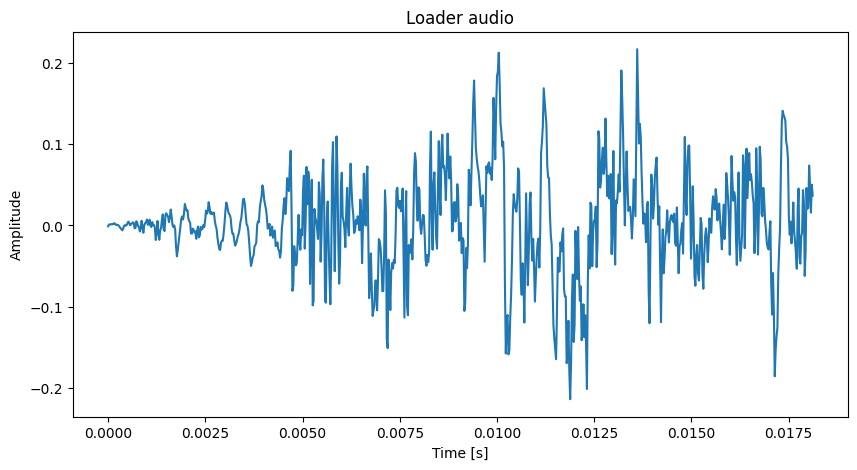

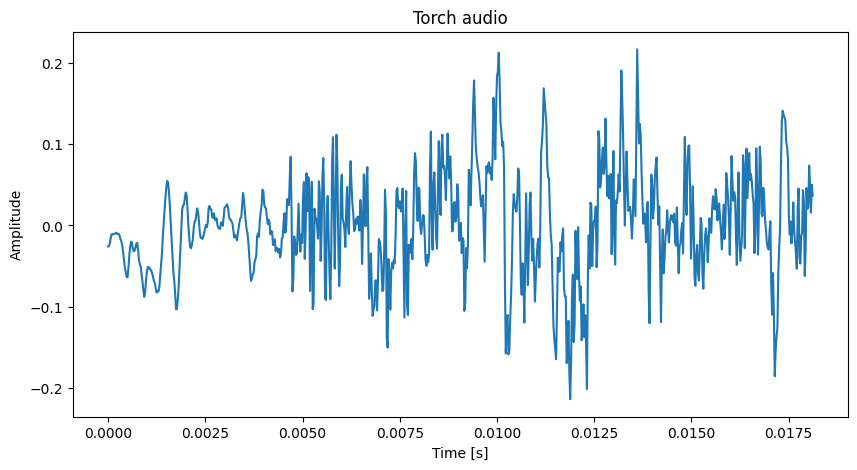

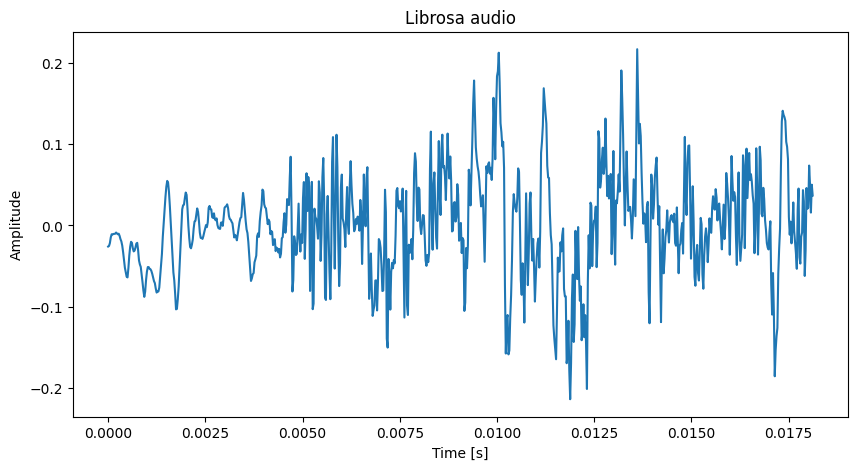

In [17]:
plot_audio(loader_audio, sample_rate, "Loader audio", num_samples=num_samples, offset=offset)
plot_audio(torch_audio.numpy(), sample_rate, "Torch audio", num_samples=num_samples, offset=offset)
plot_audio(librosa_audio, sample_rate, "Librosa audio", num_samples=num_samples, offset=offset)

In [ ]:
ipd.Audio(loader_audio.numpy(), rate=sample_rate)